In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

In [68]:
cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'session_seen', 'session_correct', 'avg_user_p_recall', 'ui_language', 'learning_language']
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
dff = pd.merge(pd.merge(df_words, df, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')
dff.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [69]:
dff.columns

Index(['gender', 'def', 'tense', 'POS', 'person', 'number', 'word_len',
       'tags_list', 'SUBTLEX', 'p_recall', 'delta', 'history_seen',
       'history_correct', 'h_recall', 'lang_combination', 'avg_delta',
       'std_delta', 'avg_h_recall'],
      dtype='object')

In [70]:
# Handle tags 
# 1) Store tags as list, but delete rows where there are less than x occurences 
dff_1 = dff.copy()
tag_counts = dff_1['tags_list'].value_counts()
rare_threshold = 1000
dff_1['tags_list'] = dff_1['tags_list'].apply(lambda x: x if tag_counts[x] > rare_threshold else 'rare')

dff_1.drop(columns=['POS', 'person', 'number', 'gender', 'tense', 'def'], inplace=True)
dff_1.dropna(inplace=True)

# 2) Store each tag as column, replace NaN values with a placeholder for categorical columns
# categorical_cols = dff.select_dtypes(include=['object']).columns.tolist()
# dff_2 = dff.copy()
# dff_2[categorical_cols] = dff_2[categorical_cols].fillna('missing')
# dff_2.drop(columns=['tags_list'], inplace=True)

In [71]:
# VIF -> iteratevily delete columns that had VIF > 10
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data
    
dff_VIF = dff_1.drop(columns=['p_recall','history_correct', 'history_seen']).sample(2000000)
vif = calculate_vif(dff_VIF.select_dtypes(exclude='O'))
vif

,Feature,VIF
0,word_len,7.960949
1,SUBTLEX,1.431312
2,delta,1.983344
3,h_recall,51.246435
4,avg_delta,4.067625
5,std_delta,3.824504
6,avg_h_recall,59.811385


In [72]:
removed_features = ["avg_h_recall", 'history_correct']
correlation_with_target = dff_1[removed_features + ["p_recall"]].corr()["p_recall"]
print(correlation_with_target)

avg_h_recall       0.164711
history_correct    0.000409
p_recall           1.000000
Name: p_recall, dtype: float64


In [73]:
dff_final = dff_1.sample(frac=0.7)
# dff_final = dff_2

In [74]:
# Transforming skewed variables
dff_final['history_wrong'] = np.log(1+(dff_final['history_seen']-dff_final['history_correct']))
dff_final['delta'] = np.log(dff_final['delta']/(60*60*24))
dff_final['avg_delta'] = np.log(dff_final['avg_delta']/(60*60*24))
dff_final['history_seen'] = np.log(1+dff_final['history_seen'])
dff_final['history_correct'] = np.log(1+dff_final['history_correct'])

In [75]:
dff_final[['word_len', 'SUBTLEX', 'delta', 'history_seen', 'history_correct', 'h_recall', 'std_delta', 'avg_h_recall', 'history_wrong', 'avg_delta', 'p_recall']].corr()['p_recall'].sort_values()

history_wrong     -0.080241
delta             -0.043143
avg_delta         -0.029242
std_delta         -0.021663
SUBTLEX           -0.011197
history_seen      -0.004011
history_correct    0.011817
word_len           0.015055
h_recall           0.103835
avg_h_recall       0.164584
p_recall           1.000000
Name: p_recall, dtype: float64

In [76]:
# Transformation of target variable 

# Logit transformation 
def logit_transform(y, epsilon=1e-10):
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

def inverse_logit_transform(y):
    return 1 / (1 + np.exp(-y))


# Log transformation 
def log_transform(y, epsilon=1e-10):
    return np.log(y + epsilon)

def inverse_log_transform(y):
    return np.exp(y)


# Box-Cox transformation
power_transformer = PowerTransformer(method='box-cox', standardize=False)
def power_transform(y, epsilon=1e-10):
    return power_transformer.fit_transform(y+epsilon) 

def inverse_power_transform(y, epsilon=1e-10):
    return power_transformer.inverse_transform(y+epsilon) 

In [77]:
# Create df without word features 
# dff_t = dff_final.drop(columns=['tags_list', 'word_len', 'SUBTLEX'], errors='ignore')

# df without SUBTLEX
# dff_t = dff_final.drop(columns=['SUBTLEX'], errors='ignore')

# DF original 
# dff_s = dff_final.drop(columns=['SUBTLEX', 'tags_list', 'word_len', 'avg_delta', 'std_delta', 'avg_h_recall', 'lang_combination', 'h_recall'], errors='ignore')

# DF without history correct and seen
# dff_s = dff_final.drop(columns=['history_correct', 'history_seen'], errors='ignore')

# DF without user columns 
# dff_u = dff_final.drop(columns=['avg_delta', 'std_delta', 'avg_h_recall', 'h_recall'], errors='ignore')

# DF without lang ui and lang native
# dff_u = dff_final.drop(columns=['ui_language', 'learning_language'], errors='ignore')


In [78]:
def ohe(df):
    """
    One-hot encode categorical variables
    """ 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([df.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded

In [79]:
def split_dataset(df):
    X = df.drop(columns='p_recall')
    y = df['p_recall']
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

In [80]:
def cap_y(prediction): 
    return np.clip(prediction, 0, 1)

In [81]:
dff_encoded = ohe(dff_final)
# dff_t_encoded = ohe(dff_t)
# dff_s_encoded = ohe(dff_s)
# dff_u_encoded = ohe(dff_u)


X_train, X_test, y_train, y_test = split_dataset(dff_encoded)
# X_train_t, X_test_t, y_train_t, y_test_t = split_dataset(dff_t_encoded)
# X_train_s, X_test_s, y_train_s, y_test_s = split_dataset(dff_s_encoded)
# X_train_u, X_test_u, y_train_u, y_test_u = split_dataset(dff_u_encoded)

In [82]:
def create_pipeline(model_type="linear", alpha=1.0, **kwargs):
    """
    Create a pipeline for regression with optional feature selection.
    
    Returns:
    - Pipeline object
    """
    if model_type == "ridge":
        model = Ridge(alpha=alpha, fit_intercept=True)
    else:
        model = LinearRegression()

    steps = [
        ('scaler', StandardScaler()),
        # ('polynomial_features', PolynomialFeatures(degree=3, include_bias=False)),
        ('model', model)
        # ('model', TransformedTargetRegressor(regressor=model, 
        #                                     func=log_transform,
        #                                     inverse_func=inverse_log_transform))
    ]
    return Pipeline(steps)

In [83]:
def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name="Model"):
    """
    Train and evaluate a pipeline, returning metrics.
    """
    pipeline.fit(X_train, y_train)

    # Predict on both train and test
    y_train_pred = cap_y(pipeline.predict(X_train))
    y_test_pred = cap_y(pipeline.predict(X_test)) 

    # Calculate metrics 
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    print(f"{name}: Train R2 = {round(train_r2, 4)}, Test R2 = {round(test_r2,4)}, Train MAE = {round(train_mae,4)}, Test MAE = {round(test_mae, 4)}")
    return y_train_pred, y_test_pred, test_mae, test_r2

In [37]:
# Define Configurations for Pipelines
pipelines_config = [
    {"name": "Linear Regression", "model_type": "linear"}
    # {"name": "Ridge Regression", "model_type": "ridge", "alpha": 100},
    # {"name": "Lasso Regression", "model_type": "lasso"},
]

def regression_results(pipelines_config, X_train, X_test, y_train, y_test, importance='No'):
    results = []
    importances = [] 
    
    for config in pipelines_config:
        pipeline = create_pipeline(**config)
        y_train_pred, y_test_pred, mae, r2 = evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name=config["name"])
        results.append((config["name"], mae, r2))

        if isinstance(importance, str) and importance == 'Yes':
            model = pipeline.named_steps["model"]
            importances.append((config["name"], X_train.columns, model.coef_))

    importance_df = pd.DataFrame(importances, columns = ['Model', 'Feature', 'Importance'])
    results_df = pd.DataFrame(results, columns=['Model', 'Test MAE', 'Test R2'])   

    full_df = X_test.copy()
    full_df['predictions'] = y_test_pred
    full_df['p_recall'] = y_test

    return results_df, importance_df, full_df

In [84]:
print('Results for all features')
results_all, importance_all, full_df_all = regression_results(pipelines_config, X_train, X_test, y_train, y_test, importance='Yes')

# print('Results after deleting word features')
# results_t, importance_t, full_df_t = regression_results(pipelines_config, X_train_t, X_test_t, y_train_t, y_test_t, importance='Yes')

# print('Results without word and user features')
# results_s, importance_s, full_df_s  = regression_results(pipelines_config, X_train_s, X_test_s, y_train_s, y_test_s, importance='Yes')

# print('Results without user features') 
# results_u, importance_u, full_df_u = regression_results(pipelines_config, X_train_u, X_test_u, y_train_u, y_test_u, importance='No')

Results for all features
Linear Regression: Train R2 = 0.0298, Test R2 = 0.0307, Train MAE = 0.1627, Test MAE = 0.1626


In [87]:
# Analyze coefficients
importance_df = importance_all.explode(["Feature", "Importance"]).reset_index(drop=True)

tags_importance = importance_df[importance_df['Feature'].str.contains("tags_list_")].copy()
overall_tags_importance = tags_importance['Importance'].abs().sum()

importance_df.head()
importance_df.loc[-1] = ['Linear Regression', 'tags_list (overall)', overall_tags_importance]  # adding a row
importance_df.index = importance_df.index + 1 


importance_df['Absolute_Val'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='Absolute_Val', ascending=False)

In [88]:
importance_df

,Model,Feature,Importance,Absolute_Val
5,Linear Regression,history_correct,0.410323,0.410323
4,Linear Regression,history_seen,-0.39934,0.39934
6,Linear Regression,h_recall,-0.046291,0.046291
9,Linear Regression,avg_h_recall,0.034023,0.034023
0,Linear Regression,tags_list (overall),0.016685,0.016685
...,...,...,...,...
121,Linear Regression,"tags_list_['vbhaver', 'pri', 'p1', 'sg']",0.000007,0.000007
170,Linear Regression,lang_combination_en-de,0.000006,0.000006
64,Linear Regression,"tags_list_['n', 'mf', 'sg']",-0.000004,0.000004
92,Linear Regression,"tags_list_['prn', 'm', 'sp']",-0.0,0.0


<Axes: >

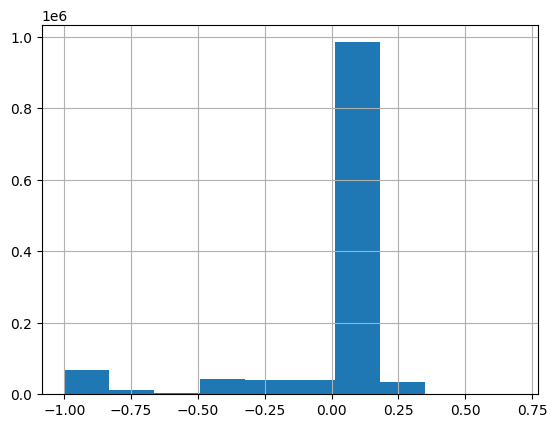

In [93]:
# Examine residuals 
full_df_all['diff'] = full_df_all['p_recall'] - full_df_all['predictions']
full_df_all['diff'].hist()


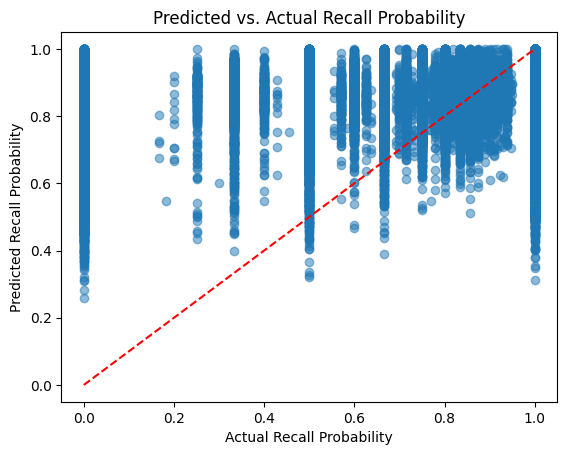

In [90]:
# Predictions vs actual recall probabilities 
plt.scatter(full_df_all['p_recall'], full_df_all['predictions'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")
plt.show()